In [99]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [63]:
df = pd.read_parquet('data/yellow_tripdata_2022-01.parquet')

In [64]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [65]:
df.shape

(2463931, 19)

In [66]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [67]:
df.duration.mean()

14.212202918831741

In [68]:
df.duration.std()

46.44530513776802

In [69]:
df[['duration', 'tip_amount']].describe(percentiles=[.25, .5, .75, .995])

,duration,tip_amount
count,2.463931e+06,2.463931e+06
mean,1.421220e+01,2.385696e+00
std,4.644531e+01,2.830698e+00
min,-3.442400e+03,-1.252200e+02
25%,6.316667e+00,7.200000e-01
50%,1.018333e+01,2.000000e+00
75%,1.616667e+01,3.000000e+00
99.5%,6.006667e+01,1.500000e+01
max,8.513183e+03,8.888800e+02


### Q3. Dropping outliers

In [80]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.27547930522405

In [81]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [82]:
df[['duration', 'tip_amount']].describe(percentiles=[.25, .5, .75, .995])

,duration,tip_amount
count,2.421440e+06,2.421440e+06
mean,1.267128e+01,2.371678e+00
std,8.999282e+00,2.697403e+00
min,1.000000e+00,-1.252200e+02
25%,6.433333e+00,1.000000e+00
50%,1.023333e+01,2.000000e+00
75%,1.613333e+01,3.000000e+00
99.5%,5.086667e+01,1.445000e+01
max,6.000000e+01,8.888800e+02


### Q4. One-hot encoding

In [85]:
categorical = ['PULocationID', 'DOLocationID']

In [86]:
df[categorical] = df[categorical].astype(str)

C:\Users\svizo\AppData\Local\Temp\ipykernel_9192\1767203464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [87]:
train_dicts = df[categorical].to_dict(orient='records')

In [92]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [93]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (2421440, 515)


### Q5. Training a model

In [94]:
target = 'duration'
y_train = df[target].values

In [95]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 6.986190837370544


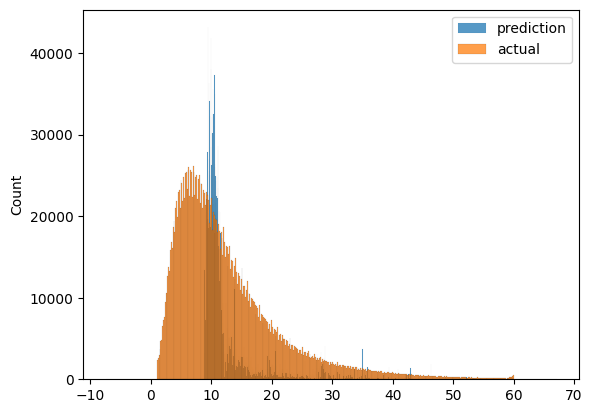

In [98]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

### Q6. Evaluating the model

In [110]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [111]:
df_val = read_data('data/yellow_tripdata_2022-02.parquet')

In [112]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [113]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [114]:
y_pred = lr.predict(X_val)

In [115]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 7.786409085078911
